<a href="https://colab.research.google.com/github/obeabi/Assignments/blob/master/Main_DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Tree Assignment 
## Written by Abiola Obembe
### Date: 2021-02-02
### Course: ML masters with deployment and deep learning
### Objective: Predicting Survival in the Titanic Data Set
-----------------------------------------------------------------------------
### ----------  Assignment starts here -------------------------------------------------

## Dataset
We will be using a decision tree to make predictions about the Titanic data
set from Kaggle. This data set provides information on the Titanic
passengers and can be used to predict whether a passenger survived or
not. You use only Pclass, Sex, Age, SibSp (Siblings aboard), Parch
(Parents/children aboard), and Fare to predict whether a passenger
survived.

In [189]:
# Loading Data and modules
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn
from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing


from sklearn.model_selection import train_test_split
from sklearn import metrics
!pip install fsspec

# Import other libraries
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category= FutureWarning)
warnings.filterwarnings("ignore", category = DeprecationWarning)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

print('Libraries installed successfully!')

np.random.seed(0)



Libraries installed successfully!


In [190]:
# Import other libraries
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [191]:
# Load dataset
url= "https://raw.githubusercontent.com/BigDataGal/Python-for-Data-Science/master/titanic-train.csv"

titanic = pd.read_csv(url)
titanic.columns =['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']

titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [192]:
# Drop columns nor required as advised from question prompt
titanic.drop(['PassengerId', 'Name','Ticket','Cabin','Embarked'], axis = 1, inplace= True)

titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500


## Explorartory Data Analysis

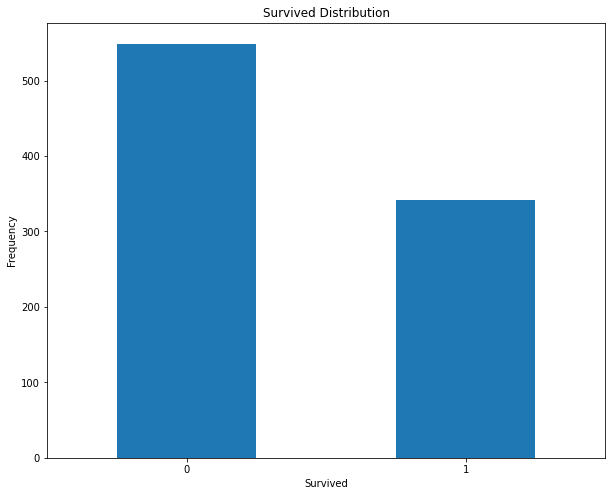

In [193]:
# Let's visualize the distribution of target data ( establishing imbalanced dataset)
count_classes = pd.value_counts(titanic['Survived'], sort = True)
count_classes.plot(kind = 'bar', rot = 0)
plt.title("Survived Distribution")
plt.xticks(range(2))
plt.xlabel("Survived")
plt.ylabel('Frequency')
plt.show()

In [194]:
# Bascic statistics
titanic.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [195]:
# Check for missing values
print("The missing values in each column are as below :")
titanic.isna().sum()

The missing values in each column are as below :


Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
dtype: int64

In [196]:
# Check if Age is missing at random
titanic.groupby(titanic['Age'].isnull()).mean()

,Survived,Pclass,Age,SibSp,Parch,Fare
Age,,,,,,
False,0.406162,2.236695,29.699118,0.512605,0.431373,34.694514
True,0.293785,2.598870,NaN,0.564972,0.180791,22.158567


We observe that 40% of the missing ages survived as compared to 20% for passengers with age not missing. This implies that Age was not missing at random. We will create an indicator variable to capture this.

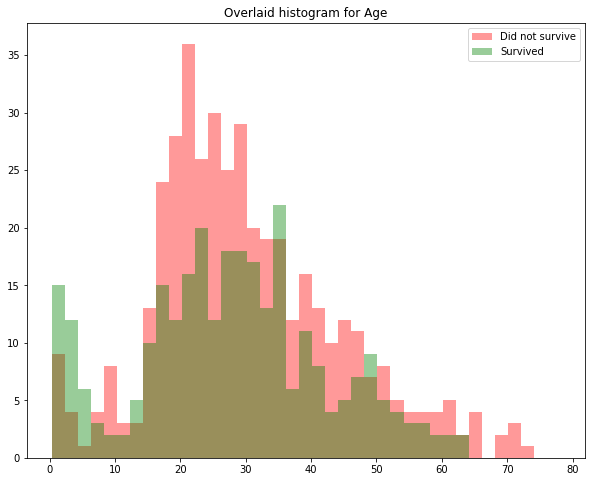

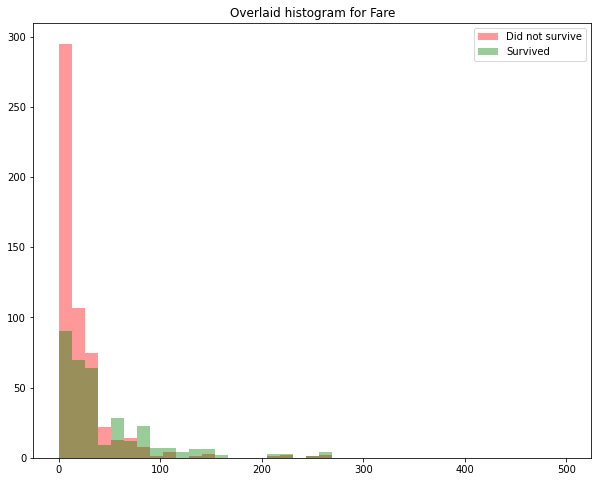

In [197]:
# Plot contiuous features
for i in ['Age', 'Fare']:
    died = list(titanic[titanic['Survived'] == 0][i].dropna())
    survived = list(titanic[titanic['Survived'] == 1][i].dropna())
    xmin = min(min(died), min(survived))
    xmax = max(max(died), max(survived))
    width = (xmax - xmin) / 40
    sns.distplot(died, color='r', kde=False, bins=np.arange(xmin, xmax, width))
    sns.distplot(survived, color='g', kde=False, bins=np.arange(xmin, xmax, width))
    plt.legend(['Did not survive', 'Survived'])
    plt.title('Overlaid histogram for {}'.format(i))
    plt.show()

<Figure size 720x576 with 0 Axes>

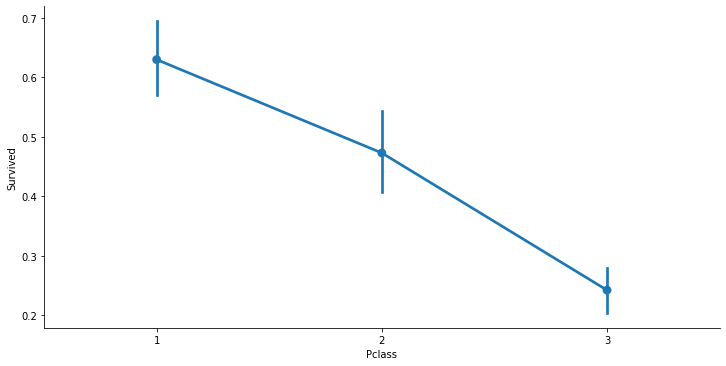

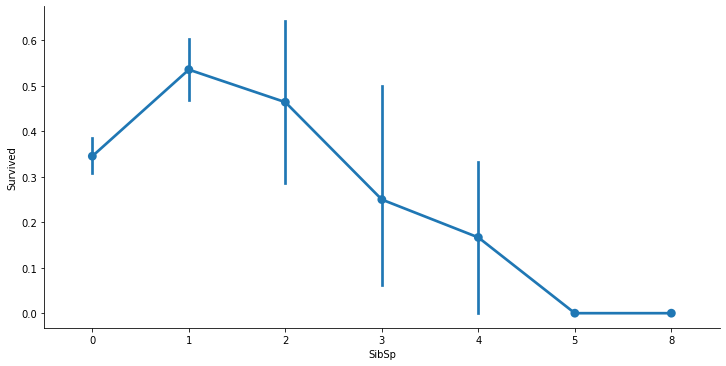

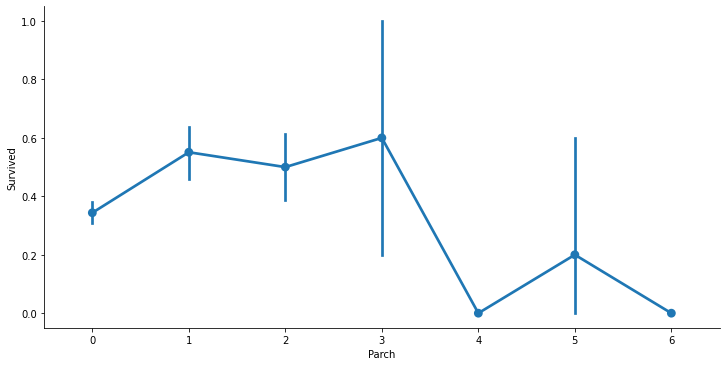

In [198]:
# Investigate the effect of Pclass, SibSP and Parch on survival
for i, col in enumerate(['Pclass', 'SibSp', 'Parch']):
    plt.figure(i)
    sns.catplot(x=col, y='Survived', data=titanic, kind='point', aspect=2,)

In [199]:
# Create indicator variablle
titanic['age_ind']= np.where(titanic['Age'].isnull(), 0,1)

# drop original Age column
titanic.drop('Age', axis=1, inplace= True)

titanic.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,age_ind
0,0,3,male,1,0,7.2500,1
1,1,1,female,1,0,71.2833,1
2,1,3,female,0,0,7.9250,1
3,1,1,female,1,0,53.1000,1
4,0,3,male,0,0,8.0500,1


In [200]:
# Print shape of dataframe
print("The shape of the dataframe is :", titanic.shape)

The shape of the dataframe is : (891, 7)


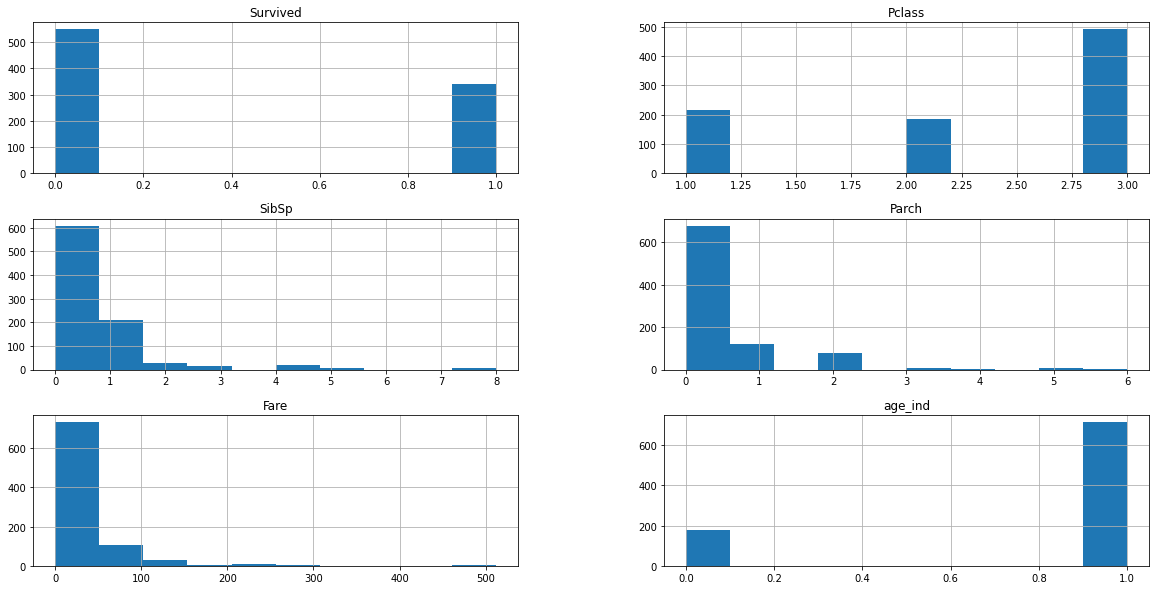

In [201]:
# Visualize histogram of dataset
titanic.hist(figsize= (20,10), bins= 10)
plt.show()

In [202]:
# Extract numerical and categorical columns from train dataframe
numerical_cols = [cname for cname in titanic.columns if
                titanic[cname].dtype in ['int64', 'float64']]

# Extract categorical features from dataframe
category_cols = [col for col in titanic.columns if titanic[col].dtype == "object"]
category_features = category_cols.copy()
category_cols.append('Survived')


In [203]:
# Let us see the cardanilatity of each column for the categorical columns in train and test set
# Unique value sin each columns
for cols in category_features:
    print("Unique values in", cols,  "column in dataset:", titanic[cols].nunique())
    print("*"*80)

Unique values in Sex column in dataset: 2
********************************************************************************


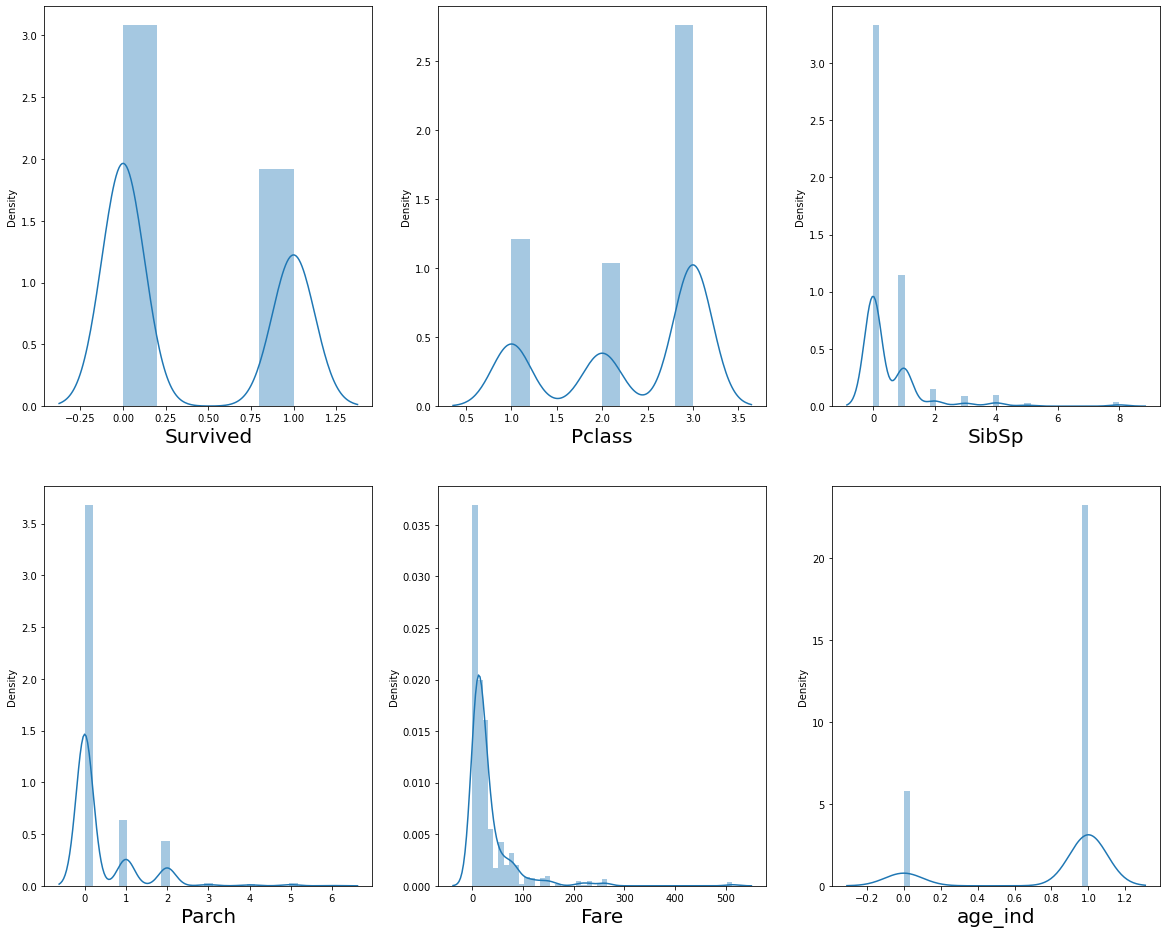

In [204]:
# let's see how data is distributed for every column
plt.figure(figsize=(20,25), facecolor='white')
plotnumber = 1

for column in titanic[numerical_cols]:
    if plotnumber<=9 :     # as there are 9 columns in the data
        ax = plt.subplot(3,3,plotnumber)
        sns.distplot(titanic[column])
        plt.xlabel(column,fontsize=20)
        #plt.ylabel('Salary',fontsize=20)
    plotnumber+=1
plt.show()

In [205]:
# Calculate the skewness and kurtosis values
for col in titanic[numerical_cols].columns:
    print(col)
    print("skewness:", titanic[col].skew())
    print("kurtosis:", titanic[col].kurtosis())
    print('-'*35)

Survived
skewness: 0.4785234382949897
kurtosis: -1.775004671066304
-----------------------------------
Pclass
skewness: -0.6305479068752845
kurtosis: -1.2800149715782825
-----------------------------------
SibSp
skewness: 3.6953517271630565
kurtosis: 17.880419726645968
-----------------------------------
Parch
skewness: 2.7491170471010933
kurtosis: 9.778125179021648
-----------------------------------
Fare
skewness: 4.787316519674893
kurtosis: 33.39814088089868
-----------------------------------
age_ind
skewness: -1.5131104860634934
kurtosis: 0.290149590230226
-----------------------------------


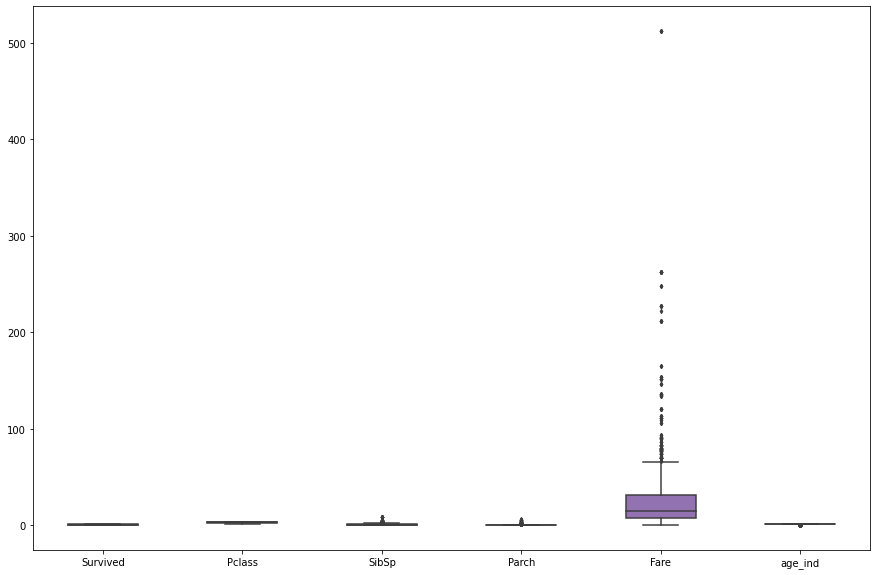

In [206]:
# Check for ouliers
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(data=titanic, width= 0.5,ax=ax,  fliersize=3)
plt.show()

In [207]:
# Check for outliers
from scipy import stats
zscore = np.abs(stats.zscore(titanic[numerical_cols]))
zscore

array([[0.78927234, 0.82737724, 0.43279337, 0.47367361, 0.50244517,
        0.49789473],
       [1.2669898 , 1.56610693, 0.43279337, 0.47367361, 0.78684529,
        0.49789473],
       [1.2669898 , 0.82737724, 0.4745452 , 0.47367361, 0.48885426,
        0.49789473],
       ...,
       [0.78927234, 0.82737724, 0.43279337, 2.00893337, 0.17626324,
        2.0084567 ],
       [1.2669898 , 1.56610693, 0.4745452 , 0.47367361, 0.04438104,
        0.49789473],
       [0.78927234, 0.82737724, 0.4745452 , 0.47367361, 0.49237783,
        0.49789473]])

In [ ]:

## For simplicity remove all data with outliers
#df_clean = df.copy()
#df_clean = df[(zscore <3).all(axis = 1)]
#print("The shape of the original dataframe is :", df.shape)
#print("The shape of the clean dataframe is :", df_clean.shape)



In [208]:
## For simplicity remove all data with outliers
q = titanic['Fare'].quantile(0.95)
# we are removing the top 10% data from the Fare column
titanic_clean = titanic[titanic['Fare']<q]


q = titanic_clean['Parch'].quantile(0.98)
# we are removing the top 2% data from the BMI column
titanic_clean  = titanic_clean[titanic_clean['Parch']<q]
q = titanic_clean['SibSp'].quantile(0.98)
# we are removing the top 2% data from the SkinThickness column
titanic_clean  = titanic_clean[titanic_clean['SibSp']<q]


deleted_entries = titanic.shape[0] - titanic_clean.shape[0]
print("Entries deleted in the dataframe are :",  deleted_entries)

Entries deleted in the dataframe are : 205


In [214]:
# Encode Gender column as onehot ecoding
data= pd.get_dummies(titanic_clean, columns=['Sex'], drop_first=True)

data.head()

,Survived,Pclass,SibSp,Parch,Fare,age_ind,Sex_male
0,0,3,1,0,7.2500,1,1
1,1,1,1,0,71.2833,1,0
2,1,3,0,0,7.9250,1,0
3,1,1,1,0,53.1000,1,0
4,0,3,0,0,8.0500,1,1


In [215]:
# Split dataset into features and target variable
X = data.drop(columns = 'Survived')
y = data['Survived']

In [216]:

# Let's move ahead and check for multicollinearity.
scaler =StandardScaler()

X_scaled = scaler.fit_transform(X)

from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = X_scaled

# we create a new data frame which will include all the VIFs
vif = pd.DataFrame()

# here we make use of the variance_inflation_factor, which will basically output the respective VIFs 
vif["VIF"] = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
# Finally, I like to include names so it is easier to explore the result
vif["Features"] = X.columns

vif

,VIF,Features
0,2.095182,Pclass
1,1.290869,SibSp
2,1.194546,Parch
3,2.318113,Fare
4,1.045851,age_ind
5,1.060555,Sex_male


Here, we have the correlation values for all the features. As a thumb rule, a VIF value greater than 5 means a very severe multicollinearity. We don't any VIF greater than 5 , so we are good to go.

Great. Let's go ahead and use linear regression and see how good it fits our data. But first. let's split our data in train and test.

In [217]:
# Split dataset into train and test set
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.18)

In [218]:
#let's first visualize the tree on the data without doing any pre processing
clf = DecisionTreeClassifier()
clf.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [219]:
feature_name=list(X.columns)
class_name = list(y_train.unique())
feature_name

['Pclass', 'SibSp', 'Parch', 'Fare', 'age_ind', 'Sex_male']

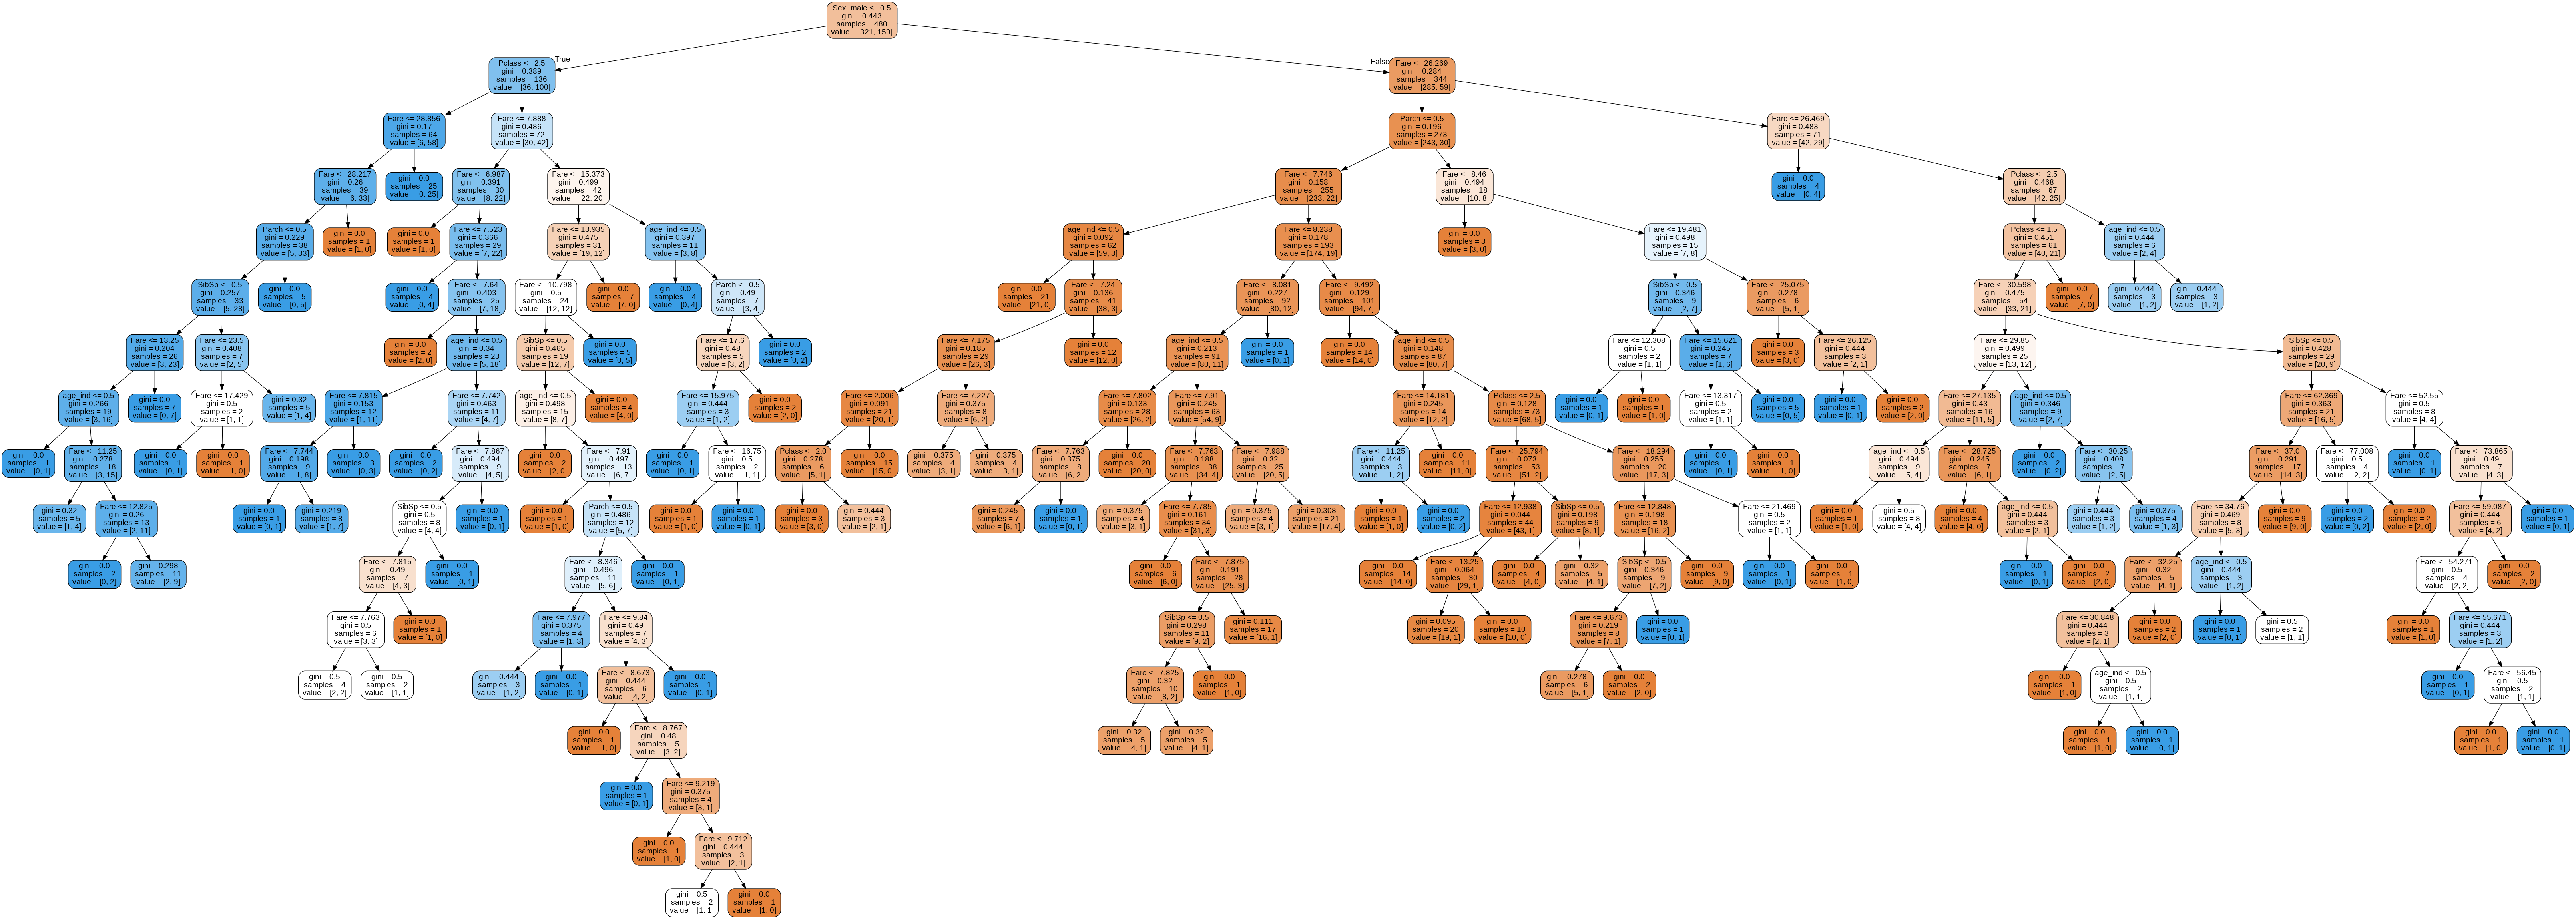

In [220]:
# create a dot_file which stores the tree structure
dot_data = export_graphviz(clf,feature_names = feature_name,rounded = True,filled = True)
# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  
graph.write_png("myTree.png")
# Show graph
Image(graph.create_png())

In [221]:
# Evaluate model on train set
clf.score(x_train,y_train)

0.9270833333333334

In [222]:
# Evaluate model on test set
# accuracy of our classification tree
clf.score(x_test,y_test)

0.7912621359223301